### correlation file info 
### [0] is an image object? 
### [1] is data table 
### with this header: 
"""
XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   88 / Bytes in row                                   
NAXIS2  =                  428 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                   13 / No. of col in table                            
TFORM1  = '1D      ' / Format of field                                          
TTYPE1  = 'field_x ' / Field label                                              
TUNIT1  = 'pixels  ' / Physical unit of field                                   
TFORM2  = '1D      ' / Format of field                                          
TTYPE2  = 'field_y ' / Field label                                              
TUNIT2  = 'pixels  ' / Physical unit of field                                   
TFORM3  = '1D      ' / Format of field                                          
TTYPE3  = 'field_ra' / Field label                                              
TUNIT3  = 'degrees ' / Physical unit of field                                   
TFORM4  = '1D      ' / Format of field                                          
TTYPE4  = 'field_dec' / Field label                                             
TUNIT4  = 'degrees ' / Physical unit of field                                   
TFORM5  = '1D      ' / Format of field                                          
TTYPE5  = 'index_x ' / Field label                                              
TUNIT5  = 'pixels  ' / Physical unit of field                                   
TFORM6  = '1D      ' / Format of field                                          
TTYPE6  = 'index_y ' / Field label                                              
TUNIT6  = 'pixels  ' / Physical unit of field                                   
TFORM7  = '1D      ' / Format of field                                          
TTYPE7  = 'index_ra' / Field label                                              
TUNIT7  = 'degrees ' / Physical unit of field                                   
TFORM8  = '1D      ' / Format of field                                          
TTYPE8  = 'index_dec' / Field label                                             
TUNIT8  = 'degrees ' / Physical unit of field                                   
TFORM9  = '1J      ' / Format of field                                          
TTYPE9  = 'index_id' / Field label                                              
TUNIT9  = 'none    ' / Physical unit of field                                   
TFORM10 = '1J      ' / Format of field                                          
TTYPE10 = 'field_id' / Field label                                              
TUNIT10 = 'none    ' / Physical unit of field                                   
TFORM11 = '1D      ' / Format of field                                          
TTYPE11 = 'match_weight' / Field label                                          
TUNIT11 = 'none    ' / Physical unit of field                                   
TFORM12 = '1E      ' / Format of field                                          
TTYPE12 = 'FLUX    ' / Field label                                              
TFORM13 = '1E      ' / Format of field                                          
TTYPE13 = 'BACKGROUND' / Field label                                            
ORIGIN  = 'ESO-QFITS' / Written by QFITS                                        
DATE    = '2023-12-07T21:16:23' / [UTC] Date of writing  
"""

In [3]:
from astropy.io import fits
from astropy.nddata import NDData
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils.psf import extract_stars, EPSFBuilder
import pandas as pd
import numpy as np
from compare_aspect.plots import centile_clip
import matplotlib.pyplot as plt 
import sys 
sys.path.append('/home/bekah/gPhoton2')
sys.path.append('/home/ubuntu/gPhoton2/gPhoton')
from gPhoton.pipeline import execute_pipeline

In [32]:
eclipse = 580
new_corr = fits.open(f'/home/bekah/glcat/corr_new_{eclipse}.fits')
old_corr = fits.open(f'/home/bekah/glcat/corr_old_{eclipse}.fits')
#old_corr = fits.open("/home/bekah/Downloads/corr.fits")

new_df=pd.DataFrame(np.array(new_corr[1].data).byteswap().newbyteorder())
old_df=pd.DataFrame(np.array(old_corr[1].data).byteswap().newbyteorder())

merged_corr = pd.merge(old_df, new_df, how='inner', on='index_id', suffixes=('_old', '_new'))

# calculate diff between star and index location 
merged_corr['old_ra_quality'] = abs(merged_corr['field_ra_old']-merged_corr['index_ra_old'])
merged_corr['old_dec_quality'] = abs(merged_corr['field_dec_old']-merged_corr['index_dec_old'])
merged_corr['new_ra_quality'] = abs(merged_corr['field_ra_new']-merged_corr['index_ra_new'])
merged_corr['new_dec_quality'] = abs(merged_corr['field_dec_new']-merged_corr['index_dec_new'])
merged_corr['flux_diff'] = merged_corr['FLUX_new']-merged_corr['FLUX_old']

In [37]:
merged_corr['quality_ra_diff'] = merged_corr['new_ra_quality']-merged_corr['old_ra_quality']
quality_ra_diff.describe()

count    417.000000
mean       0.000059
std        0.000177
min       -0.000549
25%       -0.000054
50%        0.000043
75%        0.000158
max        0.001222
dtype: float64

In [38]:
merged_corr['quality_dec_diff'] = merged_corr['new_dec_quality']-merged_corr['old_dec_quality']
quality_dec_diff.describe()

count    417.000000
mean       0.000075
std        0.000130
min       -0.000896
25%        0.000007
50%        0.000059
75%        0.000147
max        0.000765
dtype: float64

Text(0.5, 1.0, 'quality dec diff')

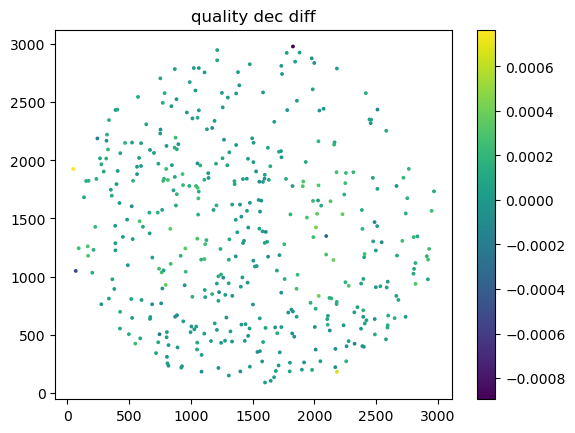

In [40]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=merged_corr['quality_dec_diff'],s=3)

plt.colorbar()
plt.title("quality dec diff")

Text(0.5, 1.0, 'old dec quality')

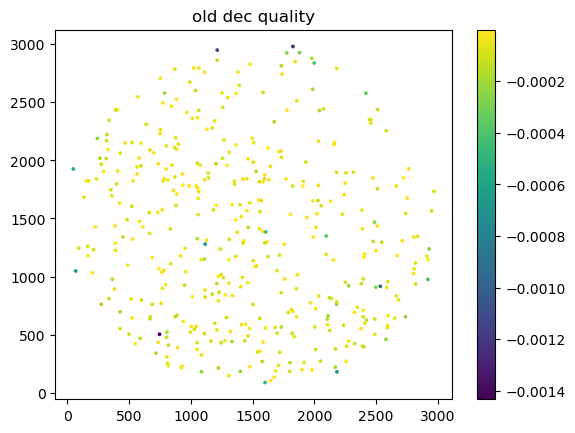

In [6]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['old_dec_quality'],s=3)

plt.colorbar()
plt.title('old dec quality')

Text(0.5, 1.0, 'new ra quality')

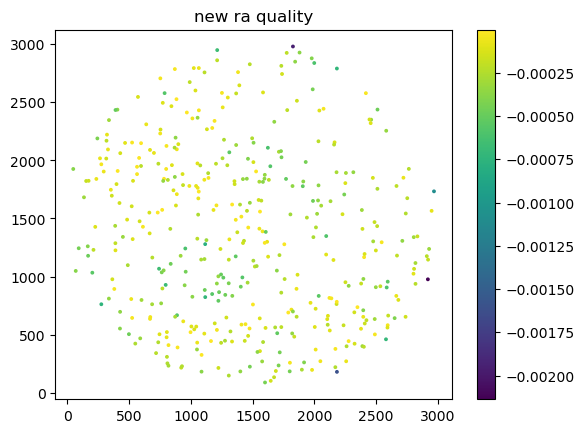

In [33]:
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['new_ra_quality'],s=3)
plt.colorbar()
plt.title("new ra quality")

Text(0.5, 1.0, 'old ra quality')

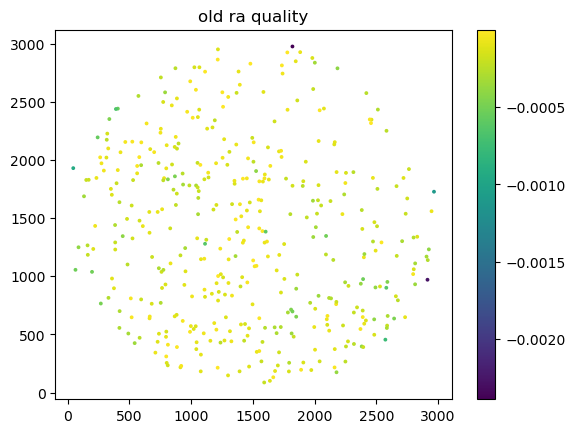

In [8]:
plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=-merged_corr['old_ra_quality'], s=3)
plt.colorbar()
plt.title("old ra quality")

Text(0.5, 1.0, 'e580')

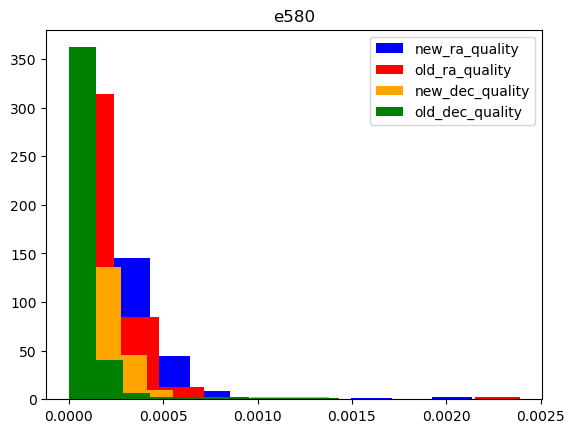

In [35]:
# plot absolute value of difference 
plt.hist(abs(merged_corr['new_ra_quality']), color='blue')
plt.hist(abs(merged_corr['old_ra_quality']), color='red')
plt.hist(abs(merged_corr['new_dec_quality']), color='orange')
plt.hist(abs(merged_corr['old_dec_quality']), color='green')
plt.legend(('new_ra_quality', 'old_ra_quality','new_dec_quality','old_dec_quality'), loc='upper right');
plt.title("e580")

In [36]:
merged_corr[['new_ra_quality', 'old_ra_quality', 'new_dec_quality', 'old_dec_quality']].describe()

,new_ra_quality,old_ra_quality,new_dec_quality,old_dec_quality
count,4.170000e+02,4.170000e+02,417.000000,4.170000e+02
mean,2.383202e-04,1.794421e-04,0.000164,8.946928e-05
std,2.220606e-04,2.059905e-04,0.000166,1.417174e-04
min,5.654746e-07,4.295057e-08,0.000002,2.745464e-07
25%,9.274885e-05,7.416424e-05,0.000063,2.417385e-05
50%,2.083386e-04,1.380423e-04,0.000130,5.611470e-05
75%,3.378522e-04,2.317595e-04,0.000226,1.018863e-04
max,2.137457e-03,2.389074e-03,0.001379,1.432335e-03


Text(0, 0.5, 'old')

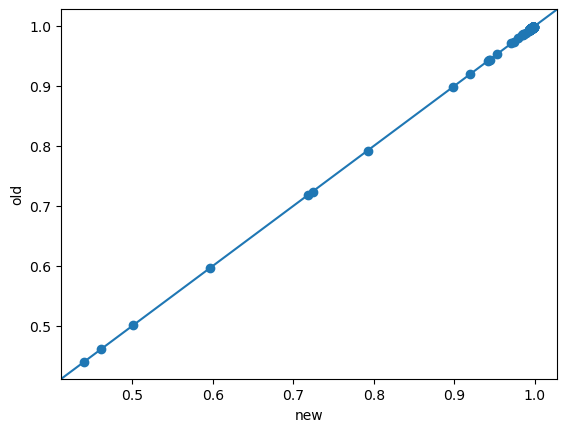

In [79]:
plt.scatter(merged_corr['match_weight_new'],merged_corr['match_weight_old'])
plt.axline((1,1),slope=1)
plt.xlabel('new')
plt.ylabel('old')

In [2]:
# checking orientation 
from pyarrow import parquet 

In [12]:
eclipse = 580

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
new_asp = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect2.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv")
meta = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/metadata.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

In [149]:
og_aspect['roll'].mean()

226.19304634813972

In [15]:
og_aspect

,eclipse,time,ra,dec,roll,flags
0,580,7.389973e+08,210.540477,-32.673776,0.001104,49
1,580,7.389973e+08,210.540048,-32.673958,0.001257,49
2,580,7.389973e+08,210.539618,-32.674159,0.001586,49
3,580,7.389973e+08,210.539168,-32.674489,0.002005,49
4,580,7.389973e+08,210.538610,-32.674799,0.002408,49
...,...,...,...,...,...,...
560,580,7.389979e+08,210.553217,-32.682498,359.994428,17
561,580,7.389979e+08,210.553309,-32.682099,359.994311,17
562,580,7.389979e+08,210.553393,-32.681649,359.994131,17
563,580,7.389979e+08,210.553432,-32.681230,359.994106,17


Text(0, 0.5, 'roll')

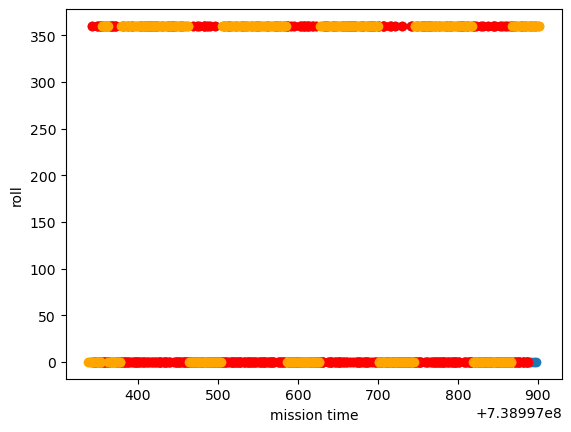

In [168]:
eclipse = 580

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv")


asp['orientation'] = abs(asp['orientation']+np.where(asp['orientation']<0, 360, 0))

difference = asp['orientation'].median()-og_aspect['roll'].median()

if difference < -4 or difference > 4: 
    difference = 0 

og_aspect['diff'] = og_aspect['roll'] + difference

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(new_asp['time'],new_asp['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')


In [169]:
asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

asp.to_csv('/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect_diff.csv')

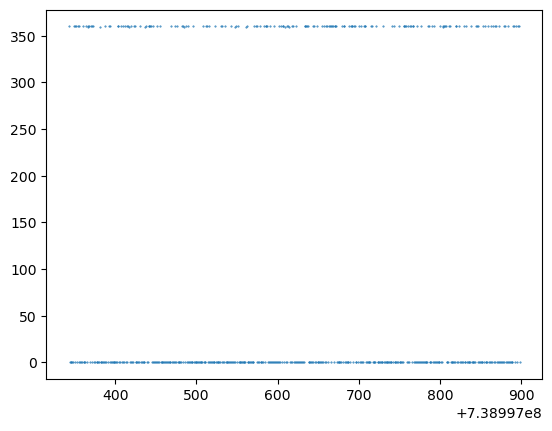

In [142]:
plt.scatter(asp['mission_time'],asp['orientation'],s=.2)

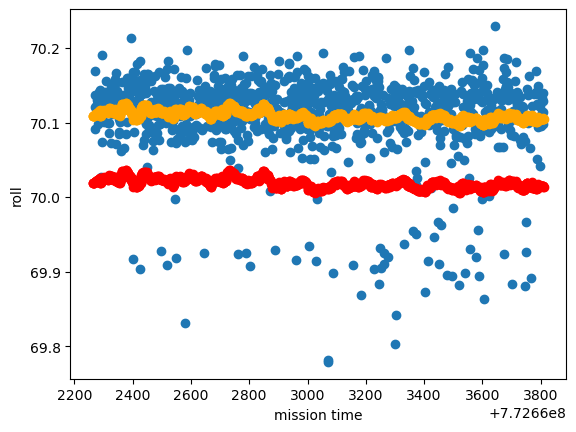

In [170]:
# 6268 

eclipse = 6268

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/06268_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

asp.to_csv('/home/bekah/gPhoton2/test_data/aspect/06268_new_aspect_diff.csv')

Text(0, 0.5, 'roll')

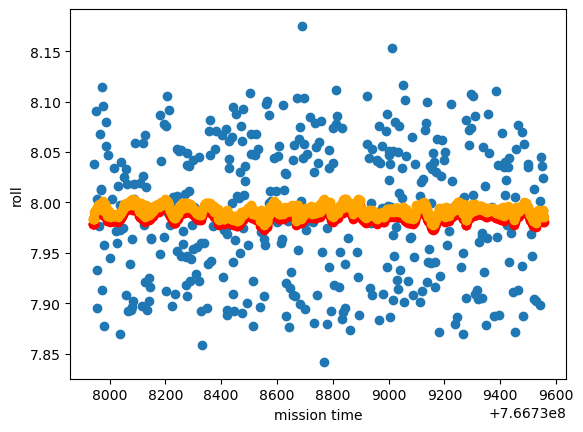

In [118]:

eclipse = 5267

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/05267_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

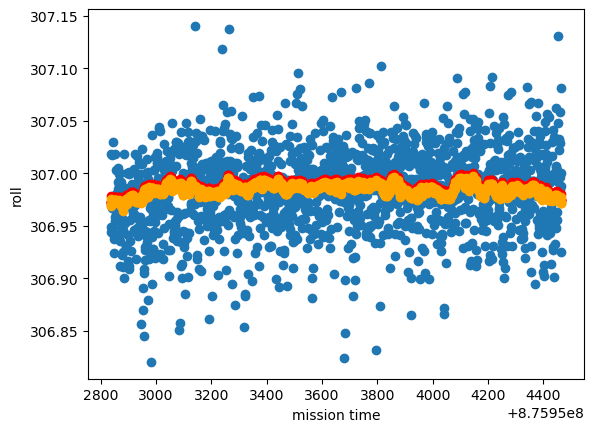

In [153]:

eclipse = 23725

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/23725_new_aspect.csv")

asp['orientation'] = abs(asp['orientation']+np.where(asp['orientation']<0, 360, 0))


difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']

og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

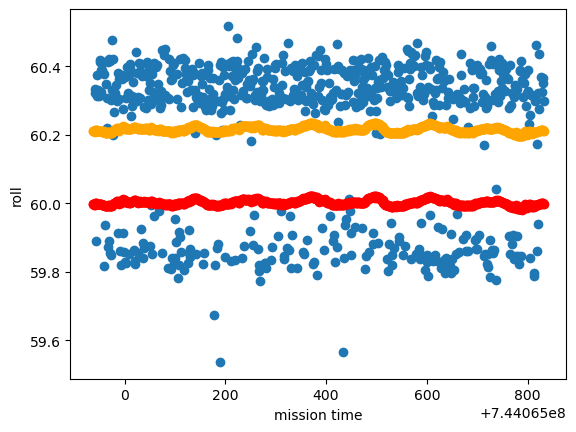

In [121]:

eclipse = 1436

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/01436_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

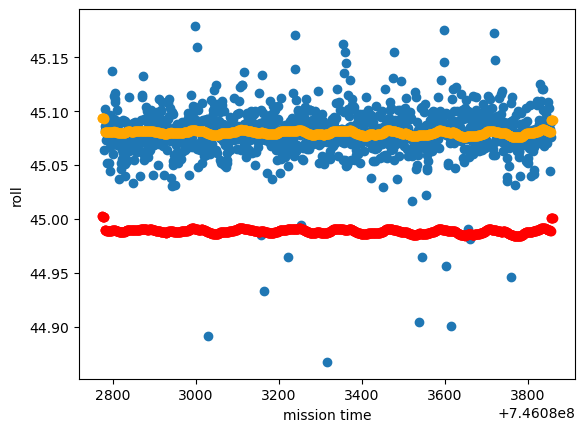

In [122]:

eclipse = 1777

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/01777_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

In [159]:
asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

,Unnamed: 0,ra,dec,roll,pixscale,ra_center,dec_center,logodds,time,frame_type,...,dec_og,roll_og,flags,orientation,eclipse_og,ra_og,dec_og,roll_og,flags_og,diff_og
0,0,4.365647,0.785823,-52.981545,1.125681,4.098938,1.155243,189.0,0.0,ref,...,1.155293,306.978437,81,306.975381,23725,4.099120,1.155293,306.978437,81,306.975381
1,1,3.989132,1.346842,-53.055740,1.124684,4.098819,1.154998,185.0,1.0,ref,...,1.155083,306.972224,0,306.969168,23725,4.098983,1.155083,306.972224,0,306.969168
2,2,3.946622,1.392268,-53.051578,1.123996,4.098525,1.154910,119.0,2.0,ref,...,1.154915,306.972577,0,306.969521,23725,4.098935,1.154915,306.972577,0,306.969521
3,3,4.360035,0.825374,-53.029130,1.125505,4.098873,1.154182,179.0,3.0,ref,...,1.154579,306.972870,0,306.969814,23725,4.098942,1.154579,306.972870,0,306.969814
4,4,3.967274,1.408522,-53.031444,1.124564,4.098714,1.154272,109.0,4.0,ref,...,1.154414,306.973253,0,306.970197,23725,4.099000,1.154414,306.973253,0,306.970197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,1625,3.870380,1.315423,-53.003890,1.123946,4.118679,1.160431,191.0,1625.0,ref,...,1.160186,306.975172,0,306.972116,23725,4.119069,1.160186,306.975172,0,306.972116
1625,1626,4.360033,0.825367,-53.075178,1.124868,4.118680,1.160779,165.0,1626.0,ref,...,1.160913,306.974892,0,306.971836,23725,4.119032,1.160913,306.974892,0,306.971836
1626,1627,4.440044,0.811222,-52.918638,1.124390,4.119034,1.161885,160.0,1627.0,ref,...,1.161611,306.974638,0,306.971582,23725,4.118863,1.161611,306.974638,0,306.971582
1627,1628,4.315554,0.788192,-53.012546,1.124235,4.118598,1.162363,134.0,1628.0,ref,...,1.162301,306.974327,0,306.971271,23725,4.118697,1.162301,306.974327,0,306.971271


TypeError: Image data of dtype object cannot be converted to float

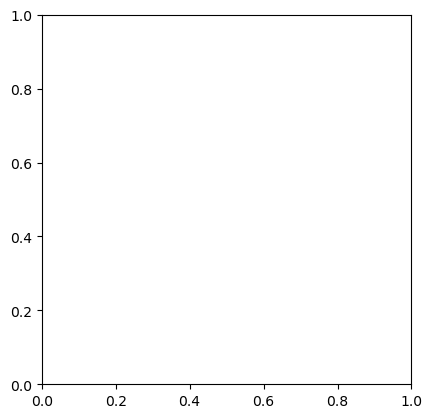

In [176]:
e68268 = fits.open("/home/bekah/gPhoton2/new_asp6268/e06268/e06268-nd-b00-ffull-image-r.fits")
plt.imshow(e68268[0].data)

In [217]:
# files 
solved = fits.open('/home/bekah/gPhoton2/og_asp_11604/e11604/e11604-nd-b00-ffull-image-r.wcs')
solved

In [218]:
solved[0].header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        292.281702577 / RA  of reference point                         
CRVAL2  =       -41.6060567923 / DEC of reference point                         
CRPIX1  =                 19

In [48]:
eclipse = 1777
new_corr = fits.open(f'/home/bekah/gPhoton2/new_asp1777/e01777/e01777-nd-b00-ffull-image-r.corr')
old_corr = fits.open(f'/home/bekah/gPhoton2/og_asp_1777/e01777/e01777-nd-b00-ffull-image-r.corr')
#old_corr = fits.open("/home/bekah/Downloads/corr.fits")

new_df=pd.DataFrame(np.array(new_corr[1].data).byteswap().newbyteorder())
old_df=pd.DataFrame(np.array(old_corr[1].data).byteswap().newbyteorder())

merged_corr = pd.merge(old_df, new_df, how='inner', on='index_ra', suffixes=('_old', '_new'))

# calculate diff between star and index location 
merged_corr['old_ra_quality'] = abs(merged_corr['field_ra_old']-merged_corr['index_ra'])
merged_corr['old_dec_quality'] = abs(merged_corr['field_dec_old']-merged_corr['index_dec_old'])
merged_corr['new_ra_quality'] = abs(merged_corr['field_ra_new']-merged_corr['index_ra'])
merged_corr['new_dec_quality'] = abs(merged_corr['field_dec_new']-merged_corr['index_dec_new'])
merged_corr['flux_diff'] = merged_corr['FLUX_new']-merged_corr['FLUX_old']

merged_corr

,field_x_old,field_y_old,field_ra_old,field_dec_old,index_x_old,index_y_old,index_ra,index_dec_old,index_id_old,field_id_old,...,index_id_new,field_id_new,match_weight_new,FLUX_new,BACKGROUND_new,old_ra_quality,old_dec_quality,new_ra_quality,new_dec_quality,flux_diff
0,2121.007812,2507.027100,338.811543,14.328401,2121.554254,2507.139557,338.811308,14.328448,19,1,...,19,1,0.998027,12452.409180,3.011719,0.000235,0.000047,0.000205,5.677984e-05,-1619.864258
1,2531.605957,1711.268921,338.635533,13.996606,2530.724731,1712.363056,338.635911,13.997062,21,4,...,21,4,0.997444,8885.739258,2.336914,0.000378,0.000456,0.000356,4.489436e-04,-1130.649414
2,1382.235962,374.312744,339.128823,13.439850,1381.705818,374.888483,339.129050,13.440090,92,6,...,92,5,0.997811,7410.263672,3.141602,0.000227,0.000240,0.000285,2.270294e-04,-838.881836
3,991.222717,2338.202148,339.297254,14.257946,991.255330,2338.328349,339.297240,14.257998,123,8,...,123,16,0.998384,2503.310303,2.607666,0.000014,0.000053,0.000015,3.334295e-05,-297.054688
4,1664.964722,285.658203,339.007696,13.402953,1663.992979,286.374159,339.008112,13.403251,12,13,...,12,13,0.997204,6747.063477,3.198730,0.000416,0.000298,0.000472,2.695242e-04,-687.694824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1451.281616,667.067383,339.099295,13.561801,1451.194467,667.281374,339.099333,13.561890,909,6440,...,909,5133,0.998568,20.782045,2.291988,0.000037,0.000089,0.000141,1.082650e-05,11.138908
565,1746.657227,498.283386,338.972695,13.491510,1746.365519,498.688906,338.972820,13.491679,159,6551,...,159,6556,0.998220,5.545821,2.288829,0.000125,0.000169,0.000024,2.199967e-04,-3.283968
566,1083.000000,560.000000,339.257096,13.517106,1082.658254,560.554016,339.257243,13.517336,545,6665,...,545,6616,0.998259,4.505733,2.908063,0.000147,0.000231,0.000119,5.023594e-07,-2.142380
567,2019.137939,734.328613,338.855872,13.589795,2019.796547,733.841274,338.855590,13.589592,538,6890,...,538,6793,0.998364,2.283880,2.331087,0.000282,0.000203,0.000250,9.728816e-05,-2.307712


In [12]:
merged_corr['field_x_old']-merged_corr['field_x_new']

0     -0.894531
1     -0.546631
2     -0.904236
3     -1.014893
4     -0.654480
         ...   
382   -1.439209
383   -0.901367
384   -1.205322
385   -1.320312
386   -1.672363
Length: 387, dtype: float64

Text(0.5, 1.0, 'old dec quality')

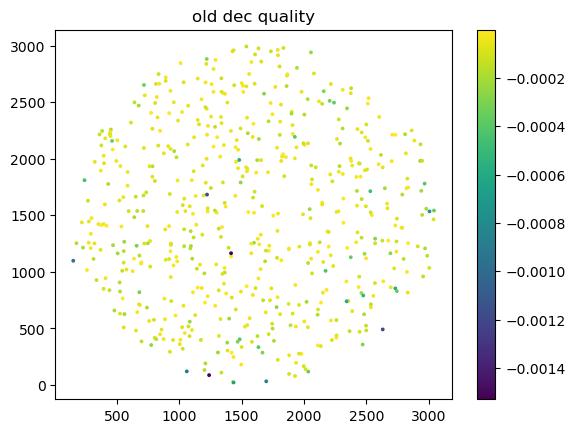

In [49]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['old_dec_quality'],s=3)

plt.colorbar()
plt.title('old dec quality')

Text(0.5, 1.0, 'new dec quality')

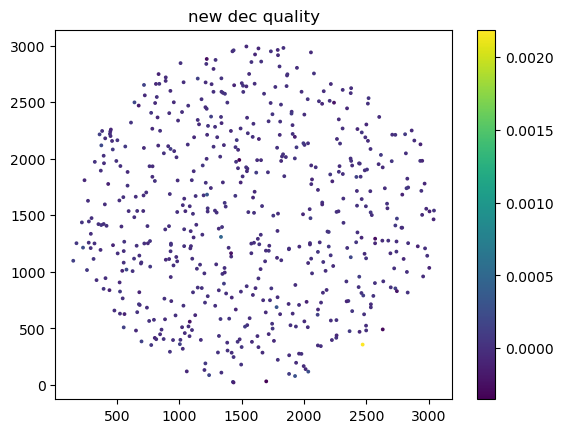

In [50]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=merged_corr['new_dec_quality']-merged_corr['old_dec_quality'],s=3)

plt.colorbar()
plt.title('new dec quality')

In [ ]:
"field" are coordinates in your image -- "field_x" and "field_y" are detected star positions.  "field_ra", "field_dec" are "field_x", "field_y" converted to RA,Dec via the WCS.

"index" are coordinates from the reference catalog -- "index_ra", "index_dec" are reference star coordinates, while "index_x", "index_y" are those converted to pixels via the WCS.

cheers,
--dustin

In [51]:
merged_corr[['new_ra_quality', 'old_ra_quality', 'new_dec_quality', 'old_dec_quality']].describe()

,new_ra_quality,old_ra_quality,new_dec_quality,old_dec_quality
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,1.346523e-04,1.317777e-04,1.136782e-04,1.093917e-04
std,2.520657e-04,2.704948e-04,1.884651e-04,1.562327e-04
min,7.750606e-08,1.988661e-08,1.149358e-07,5.043116e-08
25%,3.985423e-05,3.059259e-05,2.821037e-05,3.327928e-05
50%,7.698502e-05,7.668886e-05,6.473443e-05,6.803955e-05
75%,1.426749e-04,1.400830e-04,1.304855e-04,1.307580e-04
max,2.343751e-03,2.562922e-03,2.484828e-03,1.529532e-03


Text(0.5, 1.0, 'e11604')

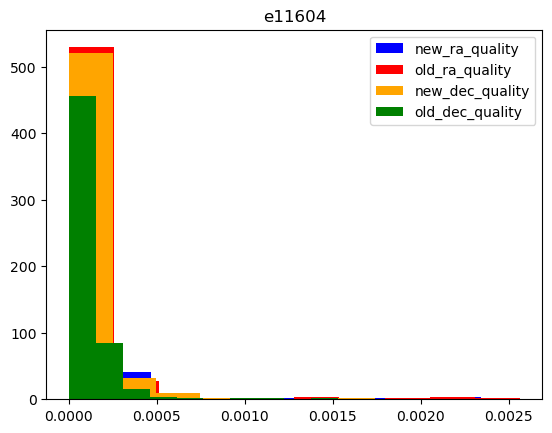

In [52]:
# plot absolute value of difference 
plt.hist(abs(merged_corr['new_ra_quality']), color='blue')
plt.hist(abs(merged_corr['old_ra_quality']), color='red')
plt.hist(abs(merged_corr['new_dec_quality']), color='orange')
plt.hist(abs(merged_corr['old_dec_quality']), color='green')
plt.legend(('new_ra_quality', 'old_ra_quality','new_dec_quality','old_dec_quality'), loc='upper right');
plt.title("e11604")

In [54]:
merged_corr['quality_dec_diff'] = merged_corr['new_dec_quality']-merged_corr['old_dec_quality']
quality_dec_diff.describe()

count    417.000000
mean       0.000075
std        0.000130
min       -0.000896
25%        0.000007
50%        0.000059
75%        0.000147
max        0.000765
dtype: float64

In [55]:
merged_corr['quality_ra_diff'] = merged_corr['new_ra_quality']-merged_corr['old_ra_quality']
quality_ra_diff.describe()

count    417.000000
mean       0.000059
std        0.000177
min       -0.000549
25%       -0.000054
50%        0.000043
75%        0.000158
max        0.001222
dtype: float64

Text(0.5, 1.0, 'quality dec diff')

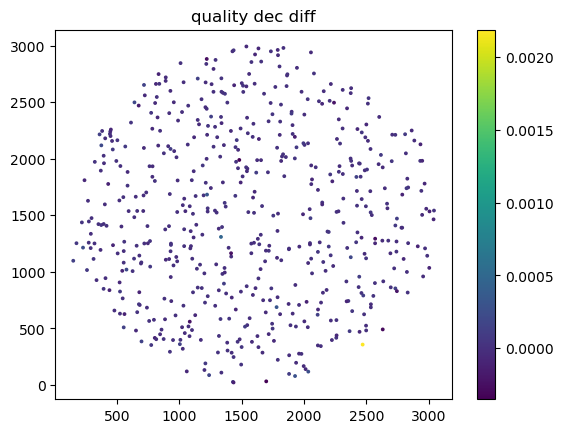

In [56]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=merged_corr['quality_dec_diff'],s=3)

plt.colorbar()
plt.title("quality dec diff")